In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.integrate import quad
from functools import partial
import numpy as np
import pyomo.environ as pyo
from pyomo.opt import TerminationCondition

[FORMULA PLACEHOLDER]

In [2]:
def matern_kernel_0p5(t_i, t_j, sigma, rho):
    d = jnp.abs(t_i - t_j)
    return sigma**2 * jnp.exp(-d / rho)

def integrated_matern_kernel_0p5(t_i, t_j, sigma, rho):
    s = t_i - t_j
    d = jnp.abs(s)

    def if_s_neg():
        return rho * (sigma**2) * (jnp.exp(-d / rho) - jnp.exp(-t_j / rho))

    def if_s_non_neg():
        return rho * (sigma**2) * (2 - jnp.exp(-d / rho) - jnp.exp(-t_j / rho))

    return jax.lax.cond(s < 0, if_s_neg, if_s_non_neg)

@partial(jax.jit, static_argnums=(2,))
def integrated_matern_kernel_matrices_0p5(t_i, t_j, sigma, rho):
    K = jax.vmap(
        jax.vmap(matern_kernel_0p5, in_axes=(None, 0, None, None)),
        in_axes=(0, None, None, None),)(t_i, t_j, sigma, rho)
    K_tilde = jax.vmap(
        jax.vmap(integrated_matern_kernel_0p5, in_axes=(None, 0, None, None)),
        in_axes=(0, None, None, None),)(t_i, t_j, sigma, rho)
    return K, K_tilde
    
#The function is defined in asset_pricing_benchmark.py
def mu_f_array(t, c, g, r, x_0):

    def x(s, c, g, x_0):
        return (x_0 + (c / g)) * jnp.exp(g * s) - (c / g)

    def discount_x(s):
        return jnp.exp(-r * s) * x(s, c, g, x_0)

    result = jnp.zeros_like(t)
    for i, t_value in enumerate(t):
        integral, err = quad(discount_x, t_value, 2000)
        result = result.at[i].set(jnp.exp(r * t_value) * integral)
    return result

Setting up the parameters

In [3]:
r = 0.1
c = 0.02
g = -0.2
x_0 = 0.01
sigma = 1.0
rho = 10
solver_type = "ipopt"
train_T = 40.0
train_points = 41
test_T = 50.0
test_points = 100
train_points_list = None
verbose = False

Traning/testing grids and kernel matrices. 

In [4]:
# if passing in `train_points` then doesn't us a grid.  Otherwise, uses linspace
if train_points_list is None:
    train_data = jnp.linspace(0, train_T, train_points)
else:
    train_data = jnp.array(train_points_list)
test_data = jnp.linspace(0, test_T, test_points)

# Construct kernel matrices
N = len(train_data)
K, K_tilde = integrated_matern_kernel_matrices_0p5(
    train_data, train_data, sigma, rho
)
K = np.array(K)  # pyomo doesn't support jax arrays
K_tilde = np.array(K_tilde)


Setting up the Pyomo model

In [5]:
# Create pyomo model and variables
m = pyo.ConcreteModel()
m.I = range(N)
m.alpha_mu = pyo.Var(m.I, within=pyo.Reals, initialize=0.0)
m.mu_0 = pyo.Var(within=pyo.NonNegativeReals, initialize=0.0)

# Map kernels to variables. Pyomo doesn't support p_0 + K_tilde @ m.alpha
def mu(m, i):
    return m.mu_0 + sum(K_tilde[i, j] * m.alpha_mu[j] for j in m.I)

def dmu_dt(m, i):
    return sum(K[i, j] * m.alpha_mu[j] for j in m.I)

def x(i):
    return (x_0 + (c / g)) * np.exp(g * i) - (c / g)


Solving the model

In [6]:
# Define constraints and objective for model and solve
@m.Constraint(m.I)
def dp_dt_constraint(m, i):
    return dmu_dt(m, i) == r * mu(m, i) - x(i)

@m.Objective(sense=pyo.minimize)
def min_norm(m):  # alpha @ K @ alpha not supported by pyomo
    return sum(K[i, j] * m.alpha_mu[i] * m.alpha_mu[j] for i in m.I for j in m.I)

solver = pyo.SolverFactory(solver_type)
options = {
    "tol": 1e-14,  # Tighten the tolerance for optimality
    "dual_inf_tol": 1e-14,  # Tighten the dual infeasibility tolerance
    "constr_viol_tol": 1e-14,  # Tighten the constraint violation tolerance
    "max_iter": 5000,  # Adjust the maximum number of iterations if needed
}
results = solver.solve(m, tee=verbose, options=options)
if not results.solver.termination_condition == TerminationCondition.optimal:
    print(str(results.solver))  # raise exception?

alpha_mu = jnp.array([pyo.value(m.alpha_mu[i]) for i in m.I])
mu_0 = pyo.value(m.mu_0)


Building the JAX interpolator and evaluating on the test grid.

In [7]:
# Interpolator using training data
@jax.jit
def kernel_solution(test_data):
    # pointwise comparison test_data to train_data
    K_test, K_tilde_test = integrated_matern_kernel_matrices_0p5(
        test_data, train_data, sigma, rho
    )
    mu_test = mu_0 + K_tilde_test @ alpha_mu
    return mu_test

mu_benchmark = mu_f_array(test_data, c, g, r, x_0)
mu_test = kernel_solution(test_data)

mu_rel_error = jnp.abs(mu_benchmark - mu_test) / mu_benchmark
print(
    f"solve_time(s) = {results.solver.Time}, E(|rel_error(p)|) = {mu_rel_error.mean()}"
)

results_dict = {
    "t_train": train_data,
    "t_test": test_data,
    "p_test": mu_test,
    "p_benchmark": mu_benchmark,
    "p_rel_error": mu_rel_error,
    "alpha": alpha_mu,
    "p_0": mu_0,
    "solve_time": results.solver.Time,
    "kernel_solution": kernel_solution,  # interpolator
}


solve_time(s) = 0.06695890426635742, E(|rel_error(p)|) = 0.00015457985864486545


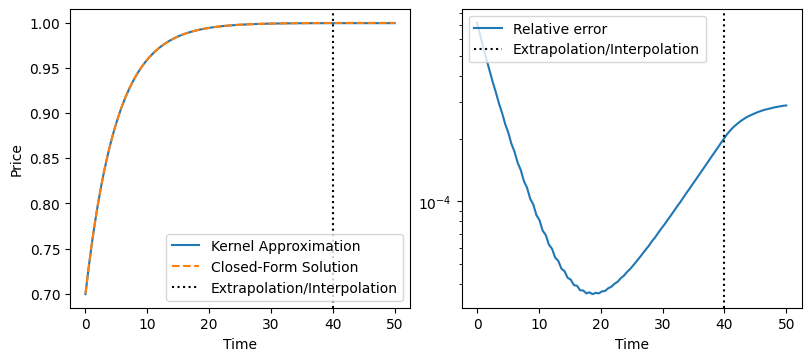

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5), constrained_layout=True)

T = float(train_data.max())

ax1.plot(test_data, mu_test, label="Kernel Approximation")
ax1.plot(test_data, mu_benchmark, linestyle="--", label="Closed-Form Solution")
ax1.axvline(T, linestyle=":", color="black", label="Extrapolation/Interpolation")
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.legend(loc="lower right")

ax2.plot(test_data, mu_rel_error, label="Relative error")
ax2.axvline(T, linestyle=":", color="black", label="Extrapolation/Interpolation")
ax2.set_xlabel("Time")
ax2.set_yscale("log")
ax2.legend(loc="upper left")

plt.show()
